# Dissertation Graphs

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import psycopg2
import math
import pandas as pd
from datetime import datetime



db_params = {
    'dbname': 'dockerdetective',
    'user': 'dockerdetective',
    'password': 'dockerdetective',
    'host': 'localhost',
    'port': '5432'
}

conn = psycopg2.connect(**db_params)
cursor = conn.cursor()

### Vulnerability Distribution

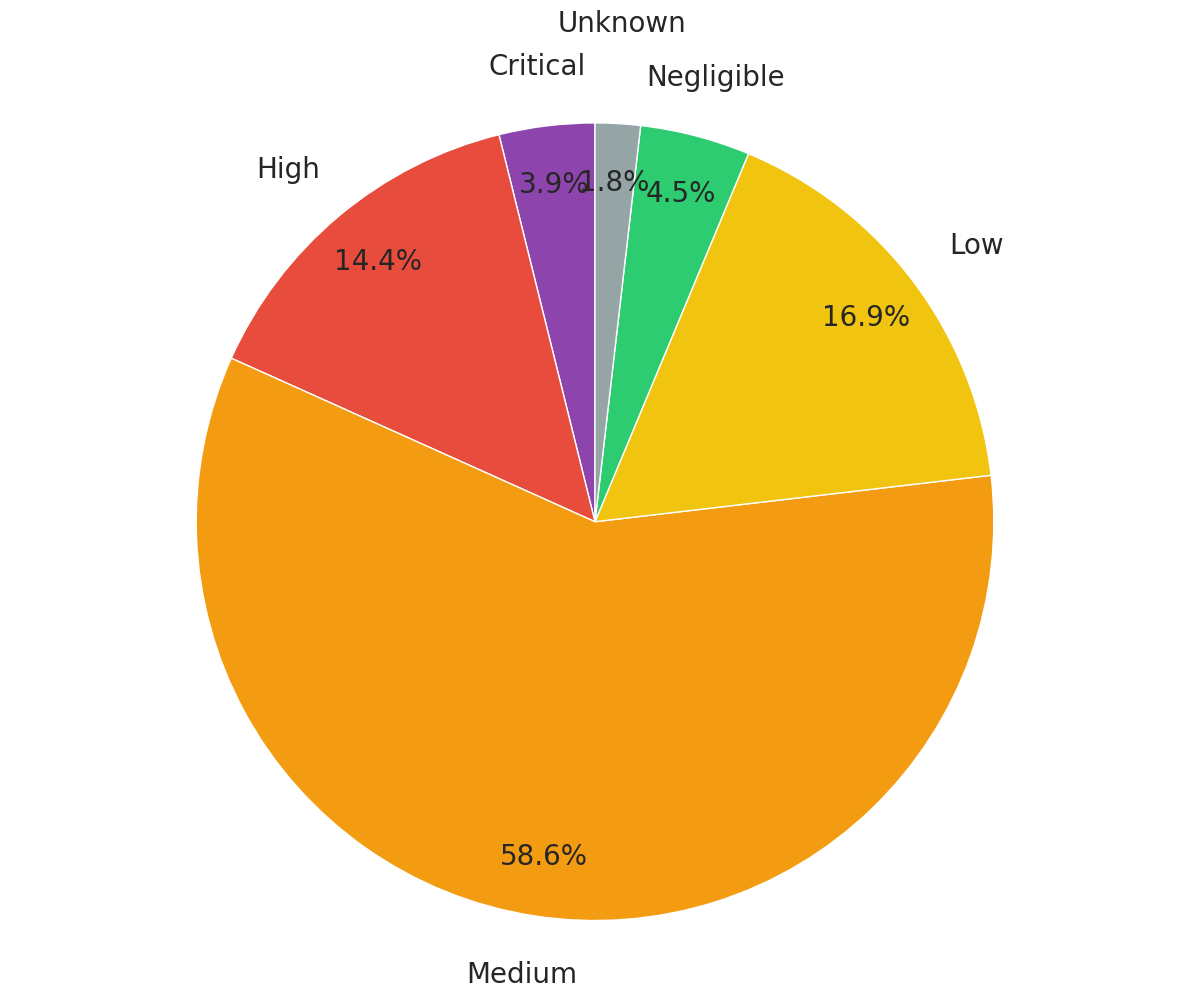

Vulnerability counts by severity:
Critical: 911
High: 3390
Medium: 13787
Low: 3966
Negligible: 1050
Unknown: 430

Unique severity levels: {'Low', 'High', 'Medium', 'Critical', 'Unknown', 'Negligible'}


In [62]:

# Query to get vulnerability counts by severity, ordered by severity level
query = """
SELECT severity, COUNT(*) as count
FROM vulnerabilities
GROUP BY severity
ORDER BY
    CASE
        WHEN UPPER(severity) = 'CRITICAL' THEN 1
        WHEN UPPER(severity) = 'HIGH' THEN 2
        WHEN UPPER(severity) = 'MEDIUM' THEN 3
        WHEN UPPER(severity) = 'LOW' THEN 4
        WHEN UPPER(severity) = 'NEGLIGIBLE' THEN 5
        WHEN UPPER(severity) = 'UNKNOWN' THEN 6
        ELSE 7
    END
"""
cursor.execute(query)
results = cursor.fetchall()

# Prepare data for the pie chart
severities = [row[0] for row in results]
counts = [row[1] for row in results]

# Calculate percentages
total = sum(counts)
percentages = [(count / total) * 100 for count in counts]

# Define color scheme
color_scheme = {
    'CRITICAL': '#8E44AD',  # Purple
    'HIGH': '#E74C3C',      # Red
    'MEDIUM': '#F39C12',    # Orange
    'LOW': '#F1C40F',       # Yellow
    'NEGLIGIBLE': '#2ECC71',# Green
    'UNKNOWN': '#95A5A6',   # Gray
    'OTHER': '#3498DB'      # Blue (for any unexpected severity levels)
}

# Get colors for each severity (case-insensitive matching)
colors = [color_scheme.get(severity.upper(), color_scheme['OTHER']) for severity in severities]

# Create the pie chart
plt.figure(figsize=(12, 10))  # Increased figure height to accommodate title
patches, texts, autotexts = plt.pie(counts, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, textprops={'fontsize': 20})

# Enhance the appearance
# plt.title('Distribution of Vulnerabilities by Severity', fontsize=24, y=1.04)  # Moved title up
plt.axis('equal')

# Add severity labels outside the pie
for i, (patch, severity) in enumerate(zip(patches, severities)):
    angle = (patch.theta2 + patch.theta1) / 2
    x = patch.r * 1.2 * math.cos(math.radians(angle))
    y = patch.r * 1.15 * math.sin(math.radians(angle))
    if severity.upper() == 'UNKNOWN':
        y = y+0.1
    plt.text(x, y, severity, ha='center', va='center', fontsize=20)

# Adjust layout
plt.tight_layout()

# Display the chart
plt.show()

# Print the data
print("Vulnerability counts by severity:")
for severity, count in results:
    print(f"{severity}: {count}")

# Print unique severity levels
print("\nUnique severity levels:", set(severities))

### Vulns Over Time

In [63]:
top_vulns_query = """
SELECT 
    v.vulnerability_name,
    v.severity,
    COUNT(*) AS occurrence_count
FROM 
    vulnerabilities v
JOIN 
    image_vulnerabilities iv ON v.vulnerability_id = iv.vulnerability_id
JOIN 
    images i ON iv.image_id = i.image_id
GROUP BY 
    v.vulnerability_id, v.vulnerability_name, v.severity
ORDER BY 
    occurrence_count DESC
LIMIT 20;
"""
cursor.execute(top_vulns_query)
# Fetch all results
results = cursor.fetchall()
# Print the results
print("Top 20 Most Common Vulnerabilities:")
print("------------------------------------")
print("{:<50} {:<10} {:<15}".format("Vulnerability Name", "Severity", "Occurrence Count"))
print("-" * 75)

for row in results:
    vulnerability_name, severity, occurrence_count = row
    print("{:<50} {:<10} {:<15}".format(vulnerability_name, severity, occurrence_count))


Top 20 Most Common Vulnerabilities:
------------------------------------
Vulnerability Name                                 Severity   Occurrence Count
---------------------------------------------------------------------------
CVE-2023-4039                                      Medium     14965          
CVE-2022-27943                                     Low        9268           
CVE-2022-0563                                      Negligible 9245           
CVE-2018-12886                                     Low        8195           
CVE-2023-50495                                     Low        7641           
CVE-2023-45918                                     Low        7641           
CVE-2022-3219                                      Low        7089           
CVE-2024-26461                                     Low        6728           
CVE-2024-26458                                     Negligible 6728           
CVE-2021-46195                                     Low        6571    

In [64]:

top_vulns_query_percentage = """
WITH scanned_images AS (
  SELECT COUNT(DISTINCT i.image_id) as total_scanned_images
  FROM images i
  WHERE i.is_scanned = true
)
SELECT 
  v.vulnerability_name,
  v.severity,
  COUNT(DISTINCT iv.image_id) as affected_images,
  si.total_scanned_images,
  (COUNT(DISTINCT iv.image_id) * 100.0 / si.total_scanned_images) as percentage
FROM 
  vulnerabilities v
JOIN 
  image_vulnerabilities iv ON v.vulnerability_id = iv.vulnerability_id
CROSS JOIN 
  scanned_images si
GROUP BY 
  v.vulnerability_id, v.vulnerability_name, v.severity, si.total_scanned_images
ORDER BY 
  percentage DESC
LIMIT 20;"""

cursor.execute(top_vulns_query_percentage)
# Fetch all results
results = cursor.fetchall()
# Print the results
print("\nTop 20 Most Common Vulnerabilities by Percentage of Affected Images:")
print("---------------------------------------------------------------------")
print("{:<50} {:<10} {:<15} {:<15} {:<15}".format("Vulnerability Name", "Severity", "Affected Images", "Total Images", "Percentage"))
print("-" * 95)

for row in results:
    vulnerability_name, severity, affected_images, total_images, percentage = row
    print("{:<50} {:<10} {:<15} {:<15} {:<15.2f}".format(vulnerability_name, severity, affected_images, total_images, percentage))
    


Top 20 Most Common Vulnerabilities by Percentage of Affected Images:
---------------------------------------------------------------------
Vulnerability Name                                 Severity   Affected Images Total Images    Percentage     
-----------------------------------------------------------------------------------------------
CVE-2023-45853                                     Medium     2086            13881           15.03          
CVE-2024-0727                                      Low        2045            13881           14.73          
CVE-2016-2781                                      Low        2006            13881           14.45          
CVE-2023-5678                                      Low        1996            13881           14.38          
CVE-2024-5535                                      Critical   1996            13881           14.38          
CVE-2024-2511                                      Unknown    1878            13881           13.53     

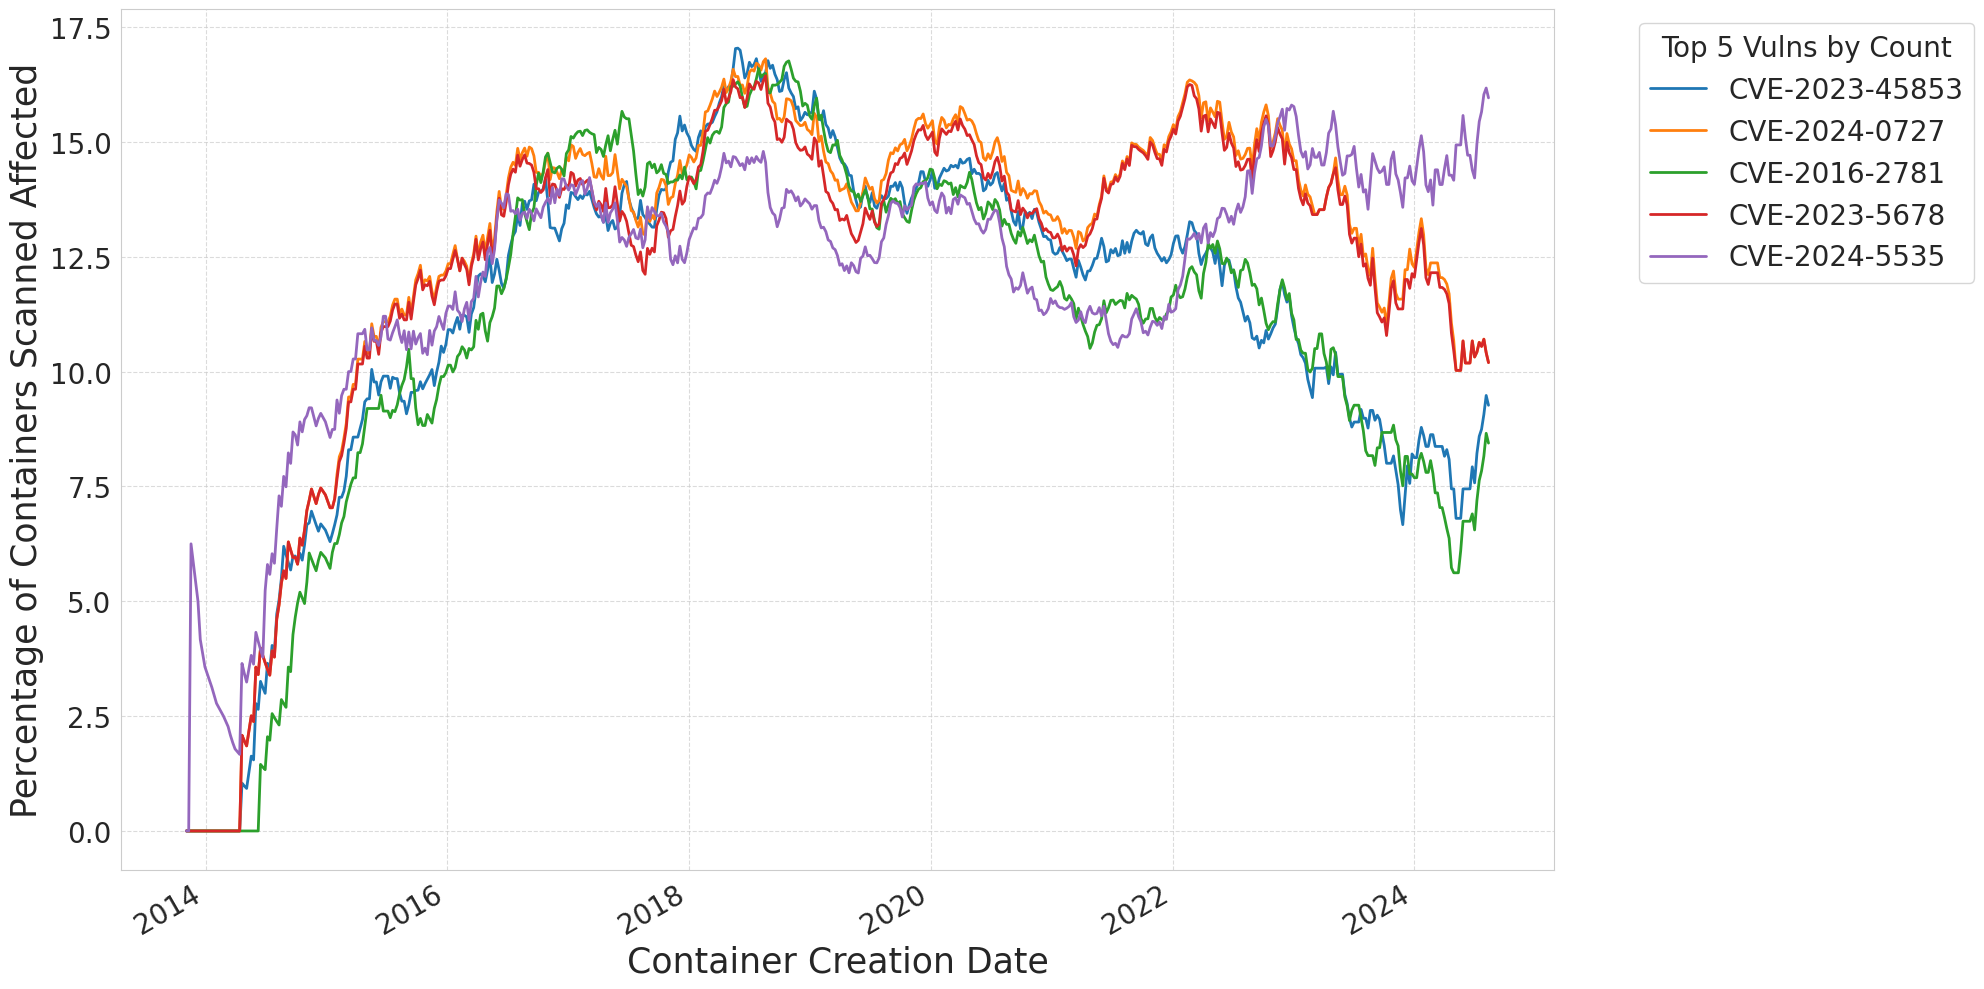

In [68]:

# Query to get the top 10 most common vulnerabilities
top_vulns_query = """
SELECT v.vulnerability_name, COUNT(DISTINCT iv.image_id) as count
FROM vulnerabilities v
JOIN image_vulnerabilities iv ON v.vulnerability_id = iv.vulnerability_id
GROUP BY v.vulnerability_name
ORDER BY count DESC
LIMIT 5;
"""

cursor.execute(top_vulns_query)
top_vulns = [row[0] for row in cursor.fetchall()]

# Query to get the percentage of images affected by each top vulnerability over time
time_series_query = """
WITH daily_scans AS (
    SELECT DATE_TRUNC('week', i.created_at) as date,
           COUNT(DISTINCT i.image_id) as total_images
    FROM images i
    WHERE i.is_scanned = true
    GROUP BY DATE_TRUNC('week', i.created_at)
),
vuln_counts AS (
    SELECT DATE_TRUNC('week', i.created_at) as date,
           v.vulnerability_name,
           COUNT(DISTINCT i.image_id) as affected_images
    FROM images i
    JOIN image_vulnerabilities iv ON i.image_id = iv.image_id
    JOIN vulnerabilities v ON iv.vulnerability_id = v.vulnerability_id
    WHERE v.vulnerability_name = ANY(%s)
    GROUP BY DATE_TRUNC('week', i.created_at), v.vulnerability_name
)
SELECT ds.date,
       vc.vulnerability_name,
       COALESCE(vc.affected_images, 0) * 100.0 / NULLIF(ds.total_images, 0) as percentage
FROM daily_scans ds
LEFT JOIN vuln_counts vc ON ds.date = vc.date
ORDER BY ds.date, vc.vulnerability_name;
"""

cursor.execute(time_series_query, (top_vulns,))
data = cursor.fetchall()


df = pd.DataFrame(data, columns=['Date', 'Vulnerability', 'Percentage'])
df['Date'] = pd.to_datetime(df['Date'])

# Convert Percentage to float
df['Percentage'] = df['Percentage'].astype(float)

# Pivot the data for easier plotting
df_pivot = df.pivot(index='Date', columns='Vulnerability', values='Percentage')

# Function to remove outliers using IQR method
def remove_outliers(series):
    series = series.dropna()
    if len(series) == 0:
        return series
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]

# Apply outlier removal to each vulnerability
for column in df_pivot.columns:
    df_pivot[column] = remove_outliers(df_pivot[column])

# Fill NaN values with 0 and apply rolling average
df_pivot = df_pivot.fillna(0).rolling(window=52, min_periods=2).mean()
df_pivot

colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.figure(figsize=(20, 10))
for vuln in top_vulns:
    if vuln in df_pivot.columns:
        plt.plot(df_pivot.index, df_pivot[vuln], label=vuln, linewidth=2, color=colours.pop(0))
        
# plt.title('Top 5 Most Common Vulnerabilities Over Time (Outliers Removed, 52-Week Moving Average)', fontsize=16)
plt.xlabel('Container Creation Date', fontsize=25)
plt.xticks(fontsize=20)
plt.ylabel('Percentage of Containers Scanned Affected', fontsize=25)
plt.yticks(fontsize=20)
plt.legend(title='Top 5 Vulns by Count', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20, title_fontsize=20)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show dates nicely
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

### Sankey Diagram

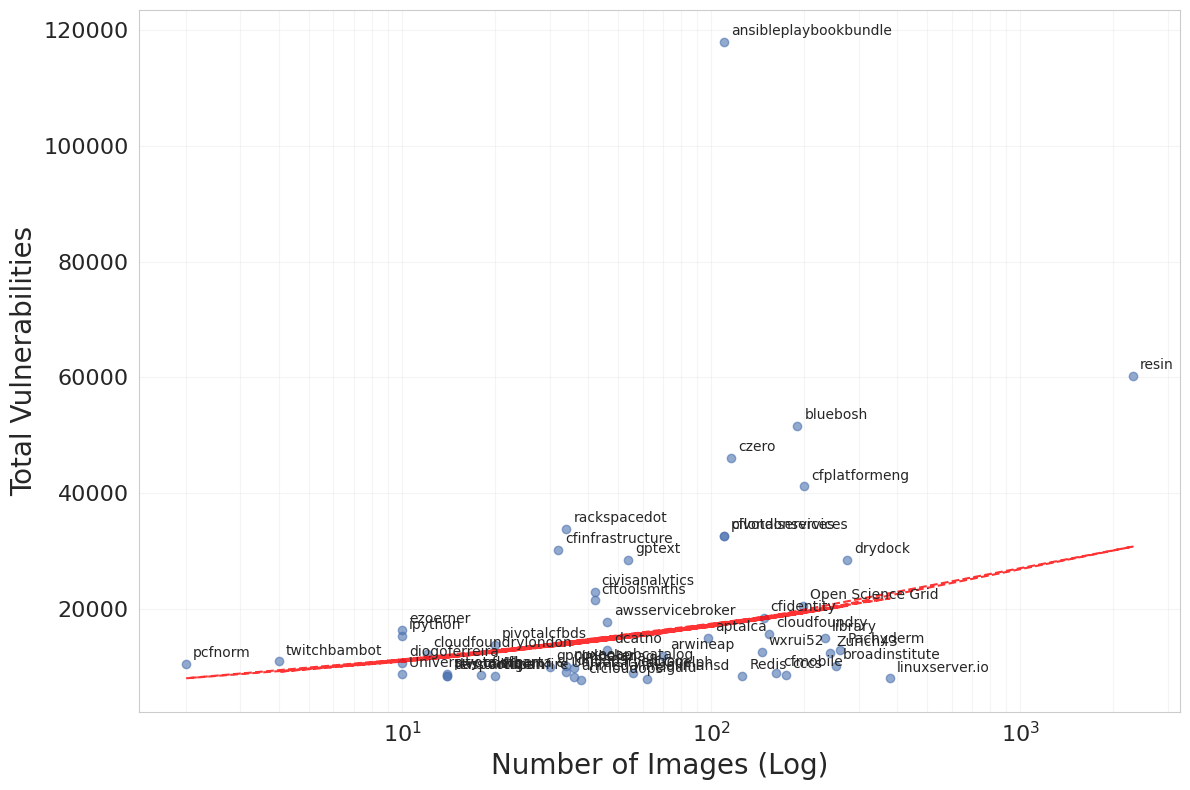

In [71]:
# SQL query to get the required data
query = """
SELECT 
    i.publisher,
    COUNT(DISTINCT i.image_id) as image_count,
    COUNT(iv.vulnerability_id) as total_vulnerabilities
FROM 
    images i
LEFT JOIN 
    image_vulnerabilities iv ON i.image_id = iv.image_id
GROUP BY 
    i.publisher
ORDER BY 
    total_vulnerabilities DESC
LIMIT 50;
"""

cursor.execute(query)
results = cursor.fetchall()


# Prepare data for plotting
publishers = [row[0] for row in results]
image_counts = [row[1] for row in results]
vulnerability_counts = [row[2] for row in results]

# Create the scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(image_counts, vulnerability_counts, alpha=0.6)

# Add labels for each point
for i, publisher in enumerate(publishers):
    plt.annotate(publisher, (image_counts[i], vulnerability_counts[i]), 
                 xytext=(5, 5), textcoords='offset points', fontsize=10)

plt.xlabel('Number of Images (Log)', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Total Vulnerabilities', fontsize=20)
plt.yticks(fontsize=16)
# plt.title('Publisher Image Count vs Total Vulnerabilities')
plt.xscale('log')  # Using log scale for better visualization if there's a wide range of values
# plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add a trend line
z = np.polyfit(np.log(image_counts), np.log(vulnerability_counts), 1)
p = np.poly1d(z)
plt.plot(image_counts, np.exp(p(np.log(image_counts))), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

In [57]:
# Query to get the total number of images scanned
cursor.execute("SELECT COUNT(*) FROM images WHERE is_scanned = TRUE")
total_scanned = cursor.fetchone()[0]

# Query to get the total number of images
cursor.execute("SELECT COUNT(*) FROM images")
total_images = cursor.fetchone()[0]

# Query to get the total number of vulnerabilities
cursor.execute("SELECT SUM(total_vulnerabilities) FROM scan_metadata")
total_vulnerabilities = cursor.fetchone()[0]

# Query to get the distribution of vulnerability severities
cursor.execute("""
    SELECT 
        SUM(critical_count) as critical,
        SUM(high_count) as high,
        SUM(medium_count) as medium,
        SUM(low_count) as low,
        SUM(negligible_count) as negligible,
        SUM(unknown_count) as unknown
    FROM scan_metadata
""")
severity_distribution = cursor.fetchone()

# Query to get the top 10 publishers by number of images
cursor.execute("""
    SELECT publisher, COUNT(*) as image_count
    FROM images
    GROUP BY publisher
    ORDER BY image_count DESC
    LIMIT 10
""")
top_publishers = cursor.fetchall()

# Print the results
print(f"Total images scanned: {total_scanned}")
print(f"Total images in database: {total_images}")
print(f"Percentage of images scanned: {(total_scanned / total_images) * 100:.2f}%")
print(f"Total vulnerabilities found: {total_vulnerabilities}")
print(f"Average vulnerabilities per scanned image: {total_vulnerabilities / total_scanned:.2f}")

print("\nVulnerability severity distribution:")
severity_labels = ['Critical', 'High', 'Medium', 'Low', 'Negligible', 'Unknown']
for label, count in zip(severity_labels, severity_distribution):
    print(f"{label}: {count}")

print("\nTop 10 publishers by number of images:")
for publisher, count in top_publishers:
    print(f"{publisher}: {count}")

Total images scanned: 13881
Total images in database: 16425939
Percentage of images scanned: 0.08%
Total vulnerabilities found: 3596399
Average vulnerabilities per scanned image: 259.09

Vulnerability severity distribution:
Critical: 118196
High: 570904
Medium: 1541704
Low: 695993
Negligible: 586476
Unknown: 64459

Top 10 publishers by number of images:
gesiscss: 181777
zongshun96: 136114
thingdust: 42734
binderhubovh: 40772
cffork8s: 40566
apachecn0: 29136
jinahub: 21374
bytez: 21133
amazeeiolagoon: 20234
yaju1145148101919: 16974


### Distribution of images scanned by date

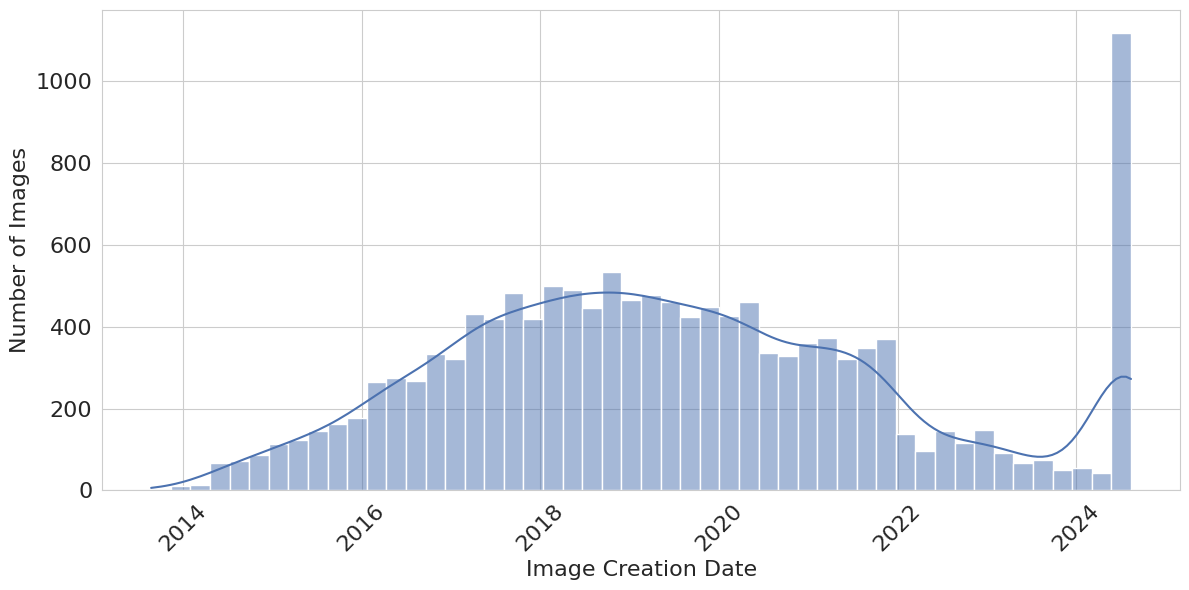

In [72]:
# SQL query to fetch scanned images and their creation dates
query = """
SELECT created_at
FROM IMAGES
WHERE is_scanned = TRUE
"""

cursor.execute(query)
results = cursor.fetchall()

# Convert results to a DataFrame
df = pd.DataFrame(results, columns=['created_at'])

# Convert 'created_at' to datetime if it's not already
df['created_at'] = pd.to_datetime(df['created_at'])

# Set up the plot style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# set colour to dark blue
sns.set_palette("deep")

# Create the histogram
sns.histplot(data=df, x='created_at', bins=50, kde=True)

# Customize the plot
# plt.title('Distribution of Scanned Docker Images by Creation Date', fontsize=16)
plt.xlabel('Image Creation Date', fontsize=16)
plt.ylabel('Number of Images', fontsize=16)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

### Image Pull Count Scanned vs Unscanned

/home/cerebralchip/.local/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/cerebralchip/.local/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


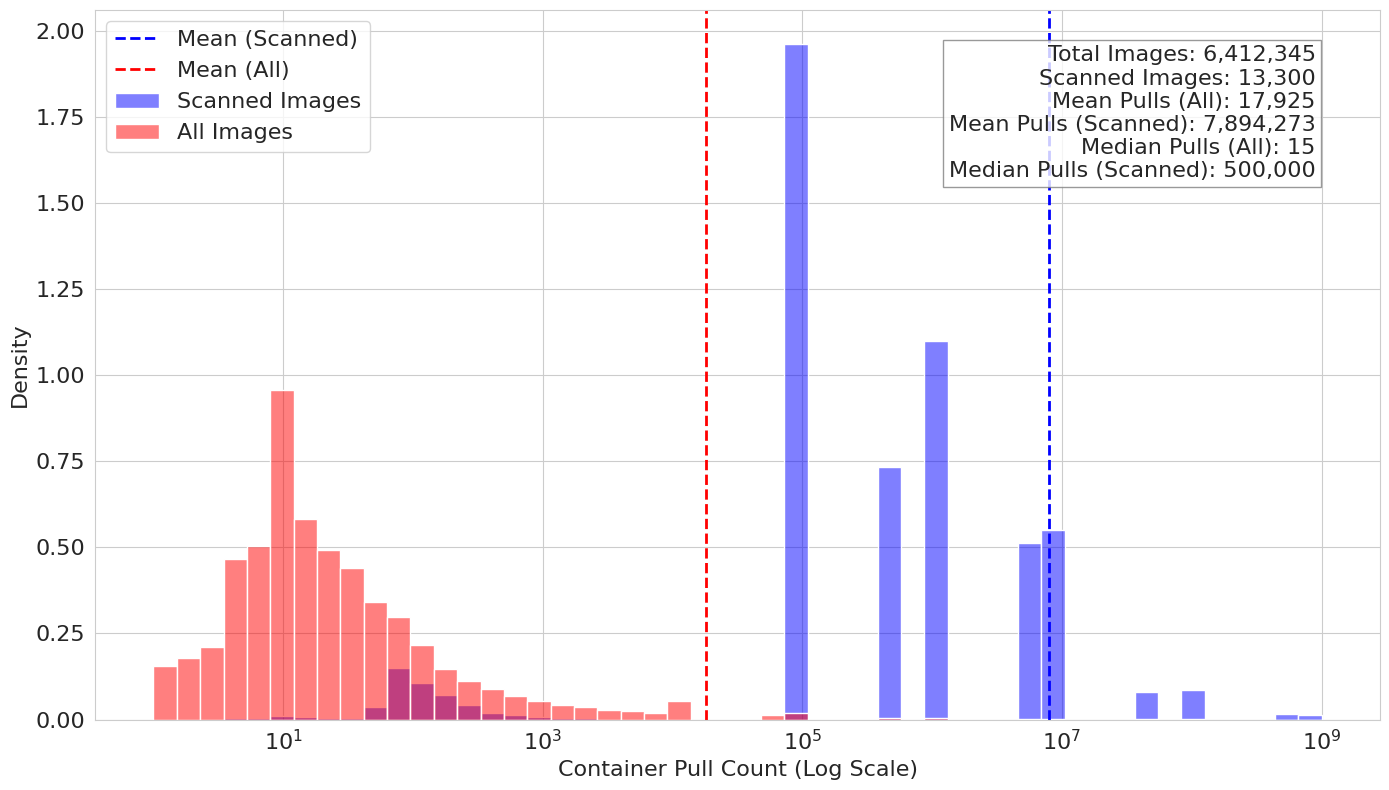

In [59]:
# SQL query to fetch pull counts of all images and scanned images
query = """
SELECT pull_count, is_scanned
FROM IMAGES
WHERE pull_count IS NOT NULL
"""

cursor.execute(query)
results = cursor.fetchall()

# Close the database connection
cursor.close()
conn.close()

# Convert results to a DataFrame
df = pd.DataFrame(results, columns=['pull_count', 'is_scanned'])

# Calculate mean pull counts
mean_pulls_all = df['pull_count'].mean()
mean_pulls_scanned = df[df['is_scanned']]['pull_count'].mean()

# Set up the plot style
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Create the normalised histogram on a logarithmic scale for both distributions
sns.histplot(data=df[df['is_scanned']], x='pull_count', bins=50, 
             stat='density', kde=True, log_scale=(True, False), color='blue', alpha=0.5, 
             label='Scanned Images')
sns.histplot(data=df, x='pull_count', bins=50, 
             stat='density', kde=True, log_scale=(True, False), color='red', alpha=0.5, 
             label='All Images')

# Add average lines
plt.axvline(mean_pulls_scanned, color='blue', linestyle='dashed', linewidth=2, label='Mean (Scanned)')
plt.axvline(mean_pulls_all, color='red', linestyle='dashed', linewidth=2, label='Mean (All)')

# Customize the plot
# plt.title('Normalised Distribution of Docker Image Pull Counts (Log Scale)', fontsize=16)
plt.xlabel('Container Pull Count (Log Scale)', fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)

# Add a text box with statistics
total_images = len(df)
scanned_images = len(df[df['is_scanned']])
median_pulls_all = df['pull_count'].median()
median_pulls_scanned = df[df['is_scanned']]['pull_count'].median()
max_pulls_all = df['pull_count'].max()
max_pulls_scanned = df[df['is_scanned']]['pull_count'].max()

stats_text = f'Total Images: {total_images:,}\n'
stats_text += f'Scanned Images: {scanned_images:,}\n'
stats_text += f'Mean Pulls (All): {mean_pulls_all:,.0f}\n'
stats_text += f'Mean Pulls (Scanned): {mean_pulls_scanned:,.0f}\n'
stats_text += f'Median Pulls (All): {median_pulls_all:,.0f}\n'
stats_text += f'Median Pulls (Scanned): {median_pulls_scanned:,.0f}'

plt.text(0.95, 0.95, stats_text, 
         transform=plt.gca().transAxes, ha='right', va='top', 
         bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8),
         fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()